Conduct Multiple Experiments ChipWhisperer into Custom File Format

In [2]:
from WPI_SCA_LIBRARY.CWScope import *
from WPI_SCA_LIBRARY.LeakageModels import *

# initialize scope
scope = CWScope("../WPI_SCA_LIBRARY/firmware/simpleserial-aes-CWLITEARM.hex")
 
# capture 1000 traces and store in an experiment named CWCapture1
scope.cw_to_file_format(1000, file_name="TestFile", experiment_name="CWCapture1", file_existing=False)

# capture 1500 traces and store in an experiment named CWCapture2
scope.cw_to_file_format(1500, file_name="TestFile", experiment_name="CWCapture2", file_existing=True)

# capture two traces sets for t-test and put into one experiment
fixed_t, rand_t = scope.capture_traces_tvla(num_traces=500)

# add t-test experiment to TestFile
file_parent = FileFormatParent("TestFile", existing=True)
file_parent.addExperiment(name="T_test", path="T_test", existing=False)

# add both datasets to file
exp = file_parent.getExperiment("T_test")

exp.createDataset("FixedTraces", "fixed", size=(500, scope.scope.adc.samples), type='uint8')
fixed_data = exp.getDataset("FixedTraces")
fixed_data.addData(index=range(500), dataToAdd=fixed_t)

exp.createDataset("RandomTraces", "random", size=(500, scope.scope.adc.samples), type='uint8')
random_data = exp.getDataset("RandomTraces")
random_data.addData(index=range(500), dataToAdd=rand_t)

(ChipWhisperer Other ERROR|File util.py:362) Setting unknown attribute offset in <class 'chipwhisperer.capture.scopes.OpenADC.OpenADC'>


Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6319 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6319 bytes


Capturing Fixed and Random Trace Sets: 100%|██████████| 500/500 [00:31<00:00, 16.10it/s]


__SNR__

{'cwcapture2traces': <WPI_SCA_LIBRARY.FileFormat.DatasetJsonClass object at 0x00000207C5F5E730>, 'cwcapture2plaintexts': <WPI_SCA_LIBRARY.FileFormat.DatasetJsonClass object at 0x00000207C5F5E460>, 'cwcapture2keys': <WPI_SCA_LIBRARY.FileFormat.DatasetJsonClass object at 0x00000207C5F5E310>, 'cwcapture2ciphertexts': <WPI_SCA_LIBRARY.FileFormat.DatasetJsonClass object at 0x00000207C5F5E400>, 'labelsb': <WPI_SCA_LIBRARY.FileFormat.DatasetJsonClass object at 0x00000207C5F5E8E0>}
{-128: [array([0.06152344, 0.05273438, 0.046875  , ..., 0.12011719, 0.15332031,
       0.15234375], dtype=float32), array([0.05957031, 0.05371094, 0.04589844, ..., 0.12402344, 0.15820312,
       0.15625   ], dtype=float32), array([0.05859375, 0.05078125, 0.04296875, ..., 0.12011719, 0.15527344,
       0.15429688], dtype=float32), array([0.05761719, 0.04980469, 0.04296875, ..., 0.125     , 0.15722656,
       0.15429688], dtype=float32), array([0.06054688, 0.05078125, 0.04589844, ..., 0.12402344, 0.15722656,
       0.

Computing Signal-To-Noise Ratio: 100%|██████████| 256/256 [00:00<00:00, 5327.77it/s]


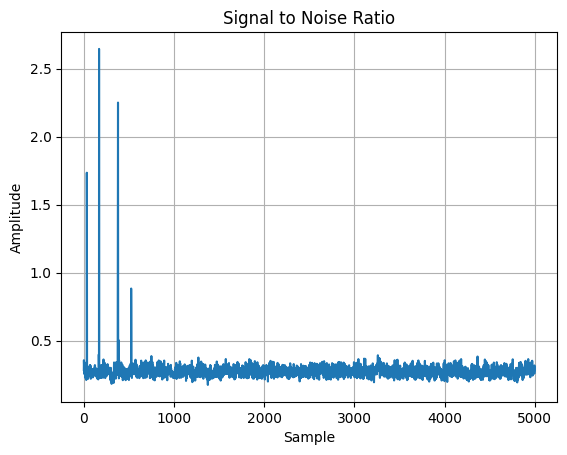

In [5]:
from WPI_SCA_LIBRARY.CWScope import *
from WPI_SCA_LIBRARY.LeakageModels import *
# read in data from CWCapture2 experiment
file = FileFormatParent("TestFile", existing=True)
experiment = file.getExperiment("CWCapture2")

print(experiment.dataset)

traces = experiment.getDataset("CWCapture2Traces").readAll()
keys = experiment.getDataset("CWCapture2Keys").readAll()
plaintexts = experiment.getDataset("CWCapture2Plaintexts").readAll()

# create labels for SNR
labels = Sbox[keys ^ plaintexts] 
labels = labels[:, 1]
labels = np.reshape(labels, (len(keys), 1))

# create a dataset in the CWCapture2 experiment to hold the labels 
experiment.createDataset("labelsB", "labelsB", size = (len(keys), 1), type = 'int8')
experiment.getDataset("labelsB").addData(range(len(keys)),labels)

# use integrated metric to run SNR 
test = experiment.calculateSNR("labelsB", "CWCapture2Traces", visualise=True, saveGraph=True)

General File Format Demo